# EarlyStopping
在 Overfitting 前停下，避免 model weights 被搞爛
注意：Earlystop 不會使模型得到更好的結果，僅是避免更糟

### [keras的EarlyStopping callbacks的使用与技巧](https://blog.csdn.net/silent56_th/article/details/72845912)
EarlyStopping则是用于提前停止训练的callbacks。具体地，可以达到当训练集上的loss不在减小（即减小的程度小于某个阈值）的时候停止继续训练

#### 为什么要用EarlyStopping
- 过拟合 
- 学习率过大导致不收敛 
- 使用正则项的时候，Loss的减少可能不是因为准确率增加导致的，而是因为权重大小的降低
- 使用EarlyStopping也可以加快学习的速度，提高调参效率

### 範例重點
* 學習如何在 keras 中加入 EarlyStop
* 知道如何設定監控目標
* 比較有無 earlystopping 對 validation 的影響

In [1]:
import os
from tensorflow import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y   

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [20]:
"""
# 載入 Callbacks, 並將 monitor 設定為監控 validation loss
"""
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="val_loss", 
                          patience=5, 
                          verbose=1
                          )

In [21]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[earlystop]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_v2_3 (Ba (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_v2_4 (Ba (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_v2_5 (Ba (None, 128)               512 

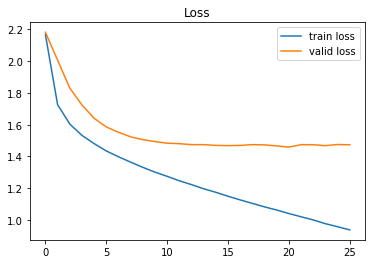

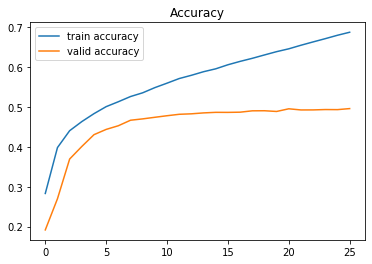

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

# 使用callbacks函數儲存model

### Model Check Point
⾃動將⽬前最佳的模型權重存下

> 假如電腦突然斷線、當機該怎麼辦? 難道我只能重新開始?
- 假如不幸斷線 : 可以重新⾃最佳的權重開始
- 假如要做 Inference :可以保證使⽤的是對 monitor metric 最佳的權重

## 範例重點
* 學習如何在 keras 中加入 model checkpoint
* 知道如何設定監控目標
* 比較使用最佳與非最佳參數時的 performance

In [6]:
from tensorflow.keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [8]:
"""
# 載入 Callbacks, 並將監控目標設為 validation loss, 且只存最佳參數時的模型
"""
from tensorflow.keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)

In [9]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# Load back
model = keras.models.load_model("./tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_v2 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_v2_2 (Ba (None, 128)               512   

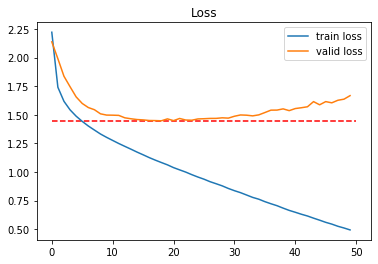

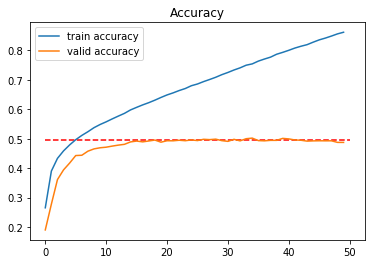

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

# reduce learning rate
 >隨訓練更新次數，將 Learning rate 逐步減⼩
- 因為通常損失函數越接近⾕底的位置，開⼝越⼩ – 需要較⼩的 Learning rate才可以再次下降

#### 可⾏的調降⽅式
- 每更新 n 次後，將 Learning rate 做⼀次調降 – schedule decay
- 當經過幾個 epoch 後，發現 performance 沒有進步 – Reduce on plateau

## 範例重點
* 學習如何在 keras 中加入 reduce learning rate
* 知道如何設定 reduce_lr 的監控目標
* 比較使用有無使用 reduce_lr 時的 performance

In [11]:
from tensorflow.keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [12]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [13]:
"""
# 載入 Callbacks, 並設定監控目標為 validation loss
"""
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

In [14]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[reduce_lr]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_v2_3 (Ba (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_v2_4 (Ba (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_v2_5 (Ba (None, 128)               512 

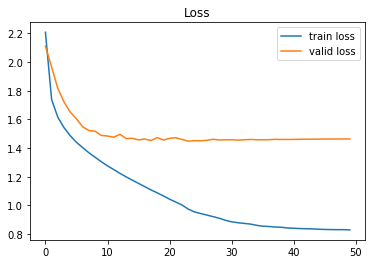

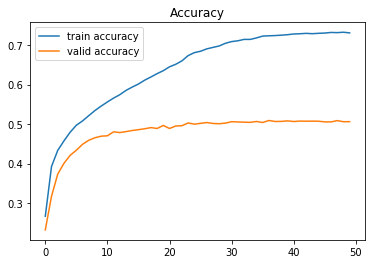

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

## Work
請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響

In [6]:
reduce_lr_factor = [0.5 , 0.1]
redice_lr_patient = [5 , 15]

In [10]:
import itertools
from tensorflow.keras.callbacks import ReduceLROnPlateau
results = {}
for (reduce_factor, reduce_patient) in itertools.product(reduce_lr_factor, redice_lr_patient):
    print("reduce_factor: %.2f, reduce_patient: %i" %(reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optim=keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = "r_factor = %s & r_patient = %s" % (str(reduce_factor),str(reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

reduce_factor: 0.50, reduce_patient: 5
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_v2_6 (Ba (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_v2_7 (Ba (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_

50000/50000 [==============================] - 7s 144us/sample - loss: 0.2913 - accuracy: 0.9361 - val_loss: 1.6446 - val_accuracy: 0.5265
Epoch 39/50
50000/50000 [==============================] - 7s 148us/sample - loss: 0.2893 - accuracy: 0.9366 - val_loss: 1.6435 - val_accuracy: 0.5275
Epoch 40/50
50000/50000 [==============================] - 7s 141us/sample - loss: 0.2880 - accuracy: 0.9377 - val_loss: 1.6485 - val_accuracy: 0.5278
Epoch 41/50
50000/50000 [==============================] - 7s 141us/sample - loss: 0.2873 - accuracy: 0.9377 - val_loss: 1.6560 - val_accuracy: 0.5266
Epoch 42/50
49152/50000 [============================>.] - ETA: 0s - loss: 0.2846 - accuracy: 0.9389
Epoch 00042: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
50000/50000 [==============================] - 7s 145us/sample - loss: 0.2843 - accuracy: 0.9390 - val_loss: 1.6518 - val_accuracy: 0.5289
Epoch 43/50
50000/50000 [==============================] - 7s 140us/sample - loss: 0.281

50000/50000 [==============================] - 7s 143us/sample - loss: 0.2873 - accuracy: 0.9193 - val_loss: 2.0076 - val_accuracy: 0.4773
Epoch 30/50
50000/50000 [==============================] - 8s 156us/sample - loss: 0.2714 - accuracy: 0.9237 - val_loss: 2.0269 - val_accuracy: 0.4859
Epoch 31/50
50000/50000 [==============================] - 7s 144us/sample - loss: 0.2473 - accuracy: 0.9328 - val_loss: 2.0747 - val_accuracy: 0.4812
Epoch 32/50
50000/50000 [==============================] - 7s 141us/sample - loss: 0.2277 - accuracy: 0.9404 - val_loss: 2.1342 - val_accuracy: 0.4777
Epoch 33/50
50000/50000 [==============================] - 7s 139us/sample - loss: 0.2135 - accuracy: 0.9445 - val_loss: 2.0085 - val_accuracy: 0.4952
Epoch 34/50
50000/50000 [==============================] - 7s 139us/sample - loss: 0.1985 - accuracy: 0.9499 - val_loss: 2.2046 - val_accuracy: 0.4900
Epoch 35/50
50000/50000 [==============================] - 8s 168us/sample - loss: 0.1879 - accuracy: 0.95

50000/50000 [==============================] - 7s 139us/sample - loss: 0.7792 - accuracy: 0.7442 - val_loss: 1.2916 - val_accuracy: 0.5498
Epoch 21/50
50000/50000 [==============================] - 7s 138us/sample - loss: 0.7760 - accuracy: 0.7447 - val_loss: 1.2935 - val_accuracy: 0.5496
Epoch 22/50
50000/50000 [==============================] - 7s 141us/sample - loss: 0.7746 - accuracy: 0.7457 - val_loss: 1.2941 - val_accuracy: 0.5495
Epoch 23/50
50000/50000 [==============================] - 7s 138us/sample - loss: 0.7728 - accuracy: 0.7468 - val_loss: 1.2949 - val_accuracy: 0.5510
Epoch 24/50
49152/50000 [============================>.] - ETA: 0s - loss: 0.7712 - accuracy: 0.7479
Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
50000/50000 [==============================] - 7s 139us/sample - loss: 0.7707 - accuracy: 0.7483 - val_loss: 1.2952 - val_accuracy: 0.5516
Epoch 25/50
50000/50000 [==============================] - 7s 138us/sample - loss: 0.76

Epoch 8/50
50000/50000 [==============================] - 7s 138us/sample - loss: 1.0951 - accuracy: 0.6152 - val_loss: 2.2321 - val_accuracy: 0.3198
Epoch 9/50
50000/50000 [==============================] - 7s 137us/sample - loss: 1.0500 - accuracy: 0.6310 - val_loss: 1.7404 - val_accuracy: 0.3953
Epoch 10/50
50000/50000 [==============================] - 7s 138us/sample - loss: 1.0047 - accuracy: 0.6497 - val_loss: 1.9704 - val_accuracy: 0.3714
Epoch 11/50
50000/50000 [==============================] - 7s 138us/sample - loss: 0.9733 - accuracy: 0.6605 - val_loss: 1.7342 - val_accuracy: 0.4158
Epoch 12/50
50000/50000 [==============================] - 7s 137us/sample - loss: 0.9326 - accuracy: 0.6733 - val_loss: 1.8479 - val_accuracy: 0.4051
Epoch 13/50
50000/50000 [==============================] - 7s 138us/sample - loss: 0.8981 - accuracy: 0.6871 - val_loss: 1.9296 - val_accuracy: 0.3947
Epoch 14/50
50000/50000 [==============================] - 7s 137us/sample - loss: 0.8529 - accu

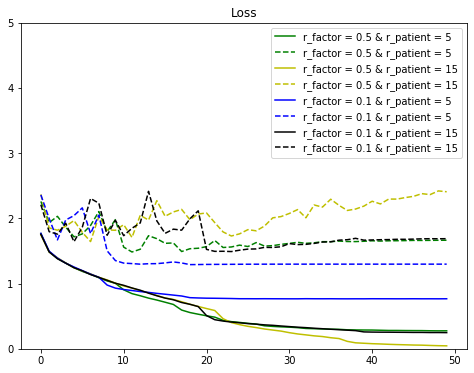

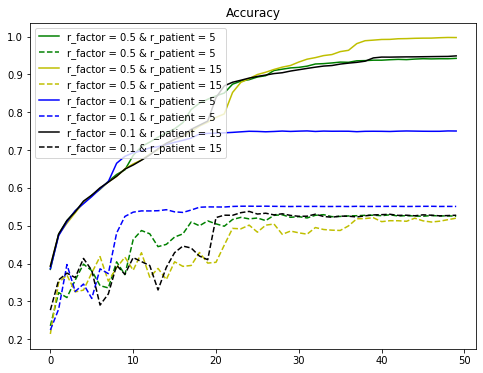

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["g", "y", "b","k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()